#Fidimag: A Basic Simulation

TODO:
- [x] imports
- [x] Meshes (+ parameters)
- [x] Material parameters
- [x] simulation object
- [x] adding energies
- [x] setting magnetisation
- [x] saving data
- [x] relax simulation
- [x] structure of m array
- [ ] define parameters to give 
- [ ] write and integrate helper functions for restructuring m
- [ ] perhaps redefine attribute names in DataReader in fileio.py...!
- [ ] viewing data

This notebook is a guide to the essential commands required to write and run basic Fidimag simulations.

The first step is to import Fidimag. Numpy and Matplotlib are also imported for later use, to demonstrate visualising simulations results.

In [1]:
import fidimag
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Meshes

                           Mesh                                              Cell
                                                                        +------------+
          +-----+-----+-----+-----+-----+-----+                        /            /|
         /     /     /     /     /     /     /|                       /            / |
        +-----+-----+-----+-----+-----+-----+ |                      /            /  | dz
       /     /     /     /     /     /     /| +                     +------------+   |
      +-----+-----+-----+-----+-----+-----+ |/          ----->      |            |   |
     /     /     /     /     /     /     /| +                       |            |   + 
    +-----+-----+-----+-----+-----+-----+ |/                        |            |  /
    |     |     |     |     |     |     | +                         |            | /  dy
    |     |     |     |     |     |     |/                          |            |/
    +-----+-----+-----+-----+-----+-----+                           +------------+
                                                                         dx

We need to create a mesh. Meshes are created by specifying the dimensions of the finite difference cells, (dx, dy, dz) and the number of cells in each direction, (nx, ny, nz).

The cell dimensions are defined by dimensionless units. The dimensions of the mesh/cells are integrated by the parameter, unit_length.

In the the following example, the (cuboid) mesh consists of 50x20x1 cells (nx=50, ny=20 and nz=1), with each cell comprising of the dimensions, dx=3, dy=3 and dz=4. The unit_length = 1e-9 (nm).

Thus, the total size of the mesh is 150nm x 60nm x 4nm.

***Required Fidimag Function***

`fidimag.common.CuboidMesh(nx, ny, nz, dx, dy, dz, unit_length)`




In [2]:
nx, ny, nz = 50, 20, 1
dx, dy, dz = 3, 3, 4 #nm
unit_length = 1e-9 # define the unit length of the dx units to nm.

mesh = fidimag.common.CuboidMesh(nx=nx, ny=ny, nz=nz, dx=dx, dy=dy, dz=dz, unit_length=unit_length)

##Creating the Simulation Object

Now we can create the simulation object.

A mesh is required to create a simulation object. We also give the simulation object a name. Is this case, we call the simulation object, 'sim_tutorial_basics'

***Required Fidimag Function***

`fidimag.micro.Sim(mesh, name)`

In [3]:
sim_name = 'sim_tutorial_basics'

sim = fidimag.micro.Sim(mesh, name=sim_name)

## Adding Interactions (and specifying material parameters)

The material specific interactions (and parameters) can now be added to the simulation object. Let's first specify the material specific parameters:

In [4]:
Ms = 1e6  # magnetisation saturation (A/m)
A = 1e-12  # exchange energy constant (J/m)
D = 1e-3  # DMI constant (J/m**2)
Ku = 1e5  # uniaxial anisotropy constant (J/m**3)
Kaxis = (0, 0, 1)  # uniaxial anisotropy axis
H = (0, 0, 1e3)  # external magnetic field (A/m)

The simulation object, sim created earlier has a property for the saturation magnetisation, Ms which is set in the following way:

In [5]:
sim.Ms = 8.0e5

Now let's add the following interactions:

- Exchange
- Uniaxial Anisotropy
- Dyzaloshinskii-Moriya (bulk)
- Zeeman Field
- Demagnetisation

***Required Fidimag Functions***

to a simulation object named, sim:

- sim.add(interaction)

where the interactions are:

| interaction         | function                                             |
|---------------------|------------------------------------------------------|
| exchange            | `fidimag.micro.UniformExchange(A)`                   |
| uniaxial anisotropy | `fidimag.micro.UniaxialAnisotropy(Ku, axis)`         |
| DMI                 | `fidimag.micro.DMI(D)`                               |
| Zeeman              | `fidimag.micro.Zeeman(H0)`                           |
| Demag               | `fidimag.micro.Demag()`                              |

In [6]:
exchange = fidimag.micro.UniformExchange(A=A)
sim.add(exchange)

anis = fidimag.micro.UniaxialAnisotropy(Ku=Ku, axis=Kaxis)
sim.add(anis)

dmi = fidimag.micro.DMI(D=D)
sim.add(dmi)

zeeman = fidimag.micro.Zeeman(H0=H)
sim.add(zeeman)

demag = fidimag.micro.Demag()
sim.add(demag)

So, at this point the Hamiltonian is created. Now, we can set parameters in the LLG equation. The sim object has properties for the values of alpha and gamma which are set in the following way:


In [7]:
sim.alpha = 0.5
sim.gamma = 2.211e5
# sim.do_precession = True

You can also specfiy whether the magnetisation spins precess or not. The sim object has a property, do_precession, which can be set to either True of False. In this example, let's have precession:

In [8]:
sim.do_precession = True

When both Hamiltonian and LLG equations are set, we need to set the intial magnetisation before we relax the system. Let's set it to all point in the x-direction:

In [9]:
m_init = (1,0,0)
sim.set_m(m_init)

## Relaxing the Simulation

The simulation object is now set up: we're now ready to relax the magnetisation.

### Time Integrator Parameters

In order to do so, we need to specify the value of dt for the time integration. By default this is set to dt=1e-11.

We also need to tell the simulation when to stop, through the desired stoppping precision, stopping\_dmdt. By default this is set to stopping\_dmdt=0.01.

The maximum number of steps, max_steps the time integrator take also needs to be specified. By default this is set to 1000.

### Data Saving Parameters

Within the relax function, when to save the magnetisation, *save\_m\_steps*, and vtk files of the magnetisation, *save\_vtk\_steps*, are also specified. By default they are set to save every 100 steps that the integrator takes. The final magnetisation is also saved. In this example we save the spatial magnetisation every 10 time steps.

When the relax function is called, a text file containing simulation data (including time, energies and average magnetisation) is created with the name sim_name.txt.

Sub-directories for the (spatial) magnetisation and vtk files are also created with the names, *sim\_name\_npys* and *sim\_name\_vtks* respectively, where the relevant data is subsequently saved. The names of these files are m\_\*.npy and m\_\*\*\*\*\*\*\*.vts respectively, where \* is replaced with the time integrator step (with leading zeros for the vts (vtk) file).

***Required Fidimag Function***

`sim.relax(dt, stopping_dmdt, max_steps, save_m_steps, save_vtk_steps)`

In [10]:
sim.relax(dt=1e-11, stopping_dmdt=0.01, max_steps=1000, save_m_steps=10, save_vtk_steps=100)

step=1, time=1e-11, max_dmdt=3822.72 ode_step=0
step=2, time=2e-11, max_dmdt=3399.28 ode_step=2.47427e-13
step=3, time=3e-11, max_dmdt=2497.6 ode_step=2.47427e-13
step=4, time=4e-11, max_dmdt=1900.29 ode_step=2.47427e-13
step=5, time=5e-11, max_dmdt=1743.91 ode_step=3.72732e-13
step=6, time=6e-11, max_dmdt=1418.26 ode_step=3.72732e-13
step=7, time=7e-11, max_dmdt=1670.83 ode_step=3.72732e-13
step=8, time=8e-11, max_dmdt=2189.17 ode_step=5.60923e-13
step=9, time=9e-11, max_dmdt=3033.34 ode_step=5.60923e-13
step=10, time=1e-10, max_dmdt=3486.69 ode_step=3.95731e-13
step=11, time=1.1e-10, max_dmdt=3289.73 ode_step=3.95731e-13
step=12, time=1.2e-10, max_dmdt=3066.47 ode_step=3.95731e-13
step=13, time=1.3e-10, max_dmdt=2851.22 ode_step=3.95731e-13
step=14, time=1.4e-10, max_dmdt=2366.89 ode_step=3.95731e-13
step=15, time=1.5e-10, max_dmdt=2204.85 ode_step=3.95731e-13
step=16, time=1.6e-10, max_dmdt=2405.97 ode_step=5.94907e-13
step=17, time=1.7e-10, max_dmdt=2459.15 ode_step=5.94907e-13
ste

#Inspecting the data

Now that a simulation has run, it is useful to inspect and visualise the generated data.

##Structure of (spatial) m array

The spatial magnetisation array from the last relaxation step can be accessed via `sim.spin`. We also saved the spatial magnetisation for all time steps into the folder *sim\_basics\_tutorial\_npys*.

The structure of `sim.spin` (and the also the data saved in the *.npy* files) is an 1-dimensional. For a mesh with *n* cells, the components are ordered as follows:

`[mx(0), my(0), mz(0), mx(1), my(1), mz(1), ..., mx(n), my(n), mz(n)]`

where the numbering of the mesh cell adheres to the following convention:

        +-------+
     .'       .:|
    +-------+:::|
    |       |:::|
    |   30  |::;+-------+-------+-------+-------+-------+
    |       |;'       .:| 11  .'  12  .'  13  .'  14  .:|
    +-------+-------+:::|---+-------+-------+-------+:::|
    |       |       |:::| .'   7  .'   8  .'   9  .:|:::|
    |   15  |  16   |::;+-------+-------+-------+:::|:::+
    |       |       |;'       .'      .'      .:|:::|::'
    +-------+-------+-------+-------+-------+:::|:::+'
    |       |       |       |       |       |:::|:.'
    |   0   |   1   |   2   |   3   |   4   |:::+'
    |       |       |       |       |       |::'
    +-------+-------+-------+-------+-------+'


##Plotting m (spatial)
There are built-in functions in fidimag to restructure this 1-D array, which is useful for creating spatial plots of the magnetisation. These are

***Required Fidimag Function***

`TODO: write built-in helper functions!!`



In [11]:
m = sim.spin
m.shape = (-1,3)
mz = m[:,2]

In [12]:
mz.shape = (nx,ny)

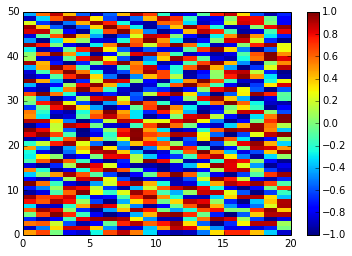

In [13]:
plt.pcolor(mz)
plt.colorbar()
plt.show()

##Plotting m (average)

It is also useful to plot the average components of m over time.

In [14]:
ls

pass.ipynb
sanitize_file
sim_tutorial_basics_npys/
sim_tutorial_basics.txt
sim_tutorial_basics_vtks/
STT_DW_motion.ipynb
tutorial-basics.ipynb


In [15]:
f  = fidimag.common.fileio.DataReader('sim_tutorial_basics.txt')

In [16]:
mz = f.datadic['m_z']
t = f.datadic['time']

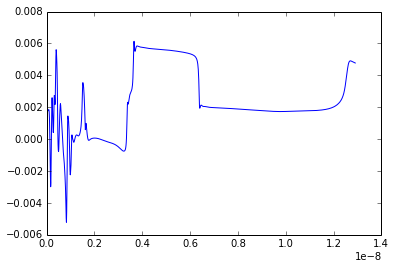

In [17]:
plt.plot(t, mz)
plt.show()